In [1]:
from nsimpkg.random_variables import BetaRV, LogitNormalRV
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm import tqdm
from nsimpkg.mcsim import rho, mcsim
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from nsimpkg.beta_OAIS import SG_OAIS_beta, Adam_OAIS_beta

plt.rcParams["figure.dpi"] = 300

In [2]:
pi = LogitNormalRV(0, 1)
# estimate the second moment of pi
second_moment = mcsim(lambda x: x**2, pi, int(1e8))
np.sqrt(second_moment - (pi.mean(int(1e9)))**2)

0.20827808073044443

We have:

$$f(x) = \frac{1}{B(\alpha,\,\beta)}x^{\alpha-1}(1-x)^{\beta-1}$$

And hence:

$$
\log f(x) = -\log B(\alpha,\,\beta) + (\alpha-1)\log x + (\beta-1)\log(1-x)
$$

Where $B(\alpha,\,\beta)$ is the beta function defined as:

$$
B(\alpha,\,\beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}
$$

And the above may be written as:

$$
\log f(x) = -\log \Gamma(\alpha) - \log\Gamma(\beta) + \log\Gamma(\alpha+\beta) + (\alpha-1)\log x + (\beta-1)\log(1-x)
$$

In this case notice that $\theta = (\alpha,\,\beta)$ and $\Theta =\mathbb{R}^+\times \mathbb{R}^+$. Once more we have:

$$
\nabla_\theta \log f = \begin{bmatrix}
\frac{\partial \log f}{\partial \alpha}\\[5pt]
\frac{\partial \log f}{\partial \beta}
\end{bmatrix}
$$

Furthermore notice that the logarithmic derivaitve of the gamma function is:

$$
\frac{\partial \log \Gamma}{\partial \alpha} = \psi^0(\alpha)
$$

Where $\psi^0$ is the digamma function, implemented in `scipy.special.digamma`. Hence we have:

$$
\nabla_\theta \log f = \begin{bmatrix}
-\psi^0(\alpha) + \psi^0(\alpha+\beta) + \log x\\[5pt]
-\psi^0(\beta) + \psi^0(\alpha+\beta) + \log(1-x)
\end{bmatrix}
$$

We will take $\pi$ to be a logit-normal distribution, with parameters $\mu$ and $\sigma$; this has density:

$$
\pi(x) = \frac{1}{\sigma\sqrt{2\pi}}\frac{1}{x(1-x)}\exp\left(-\frac{(\text{logit}(x)-\mu)^2}{2\sigma^2}\right)
$$



therefore, given $(x_i)_{i=1}^N$ samples s.t. $x_i\sim q_{\theta_k}$ where $q_{\theta_k}$ is a beta distribution with parameters $\theta_k :=(\alpha_k,\,\beta_k)$, the SG-OAIS update step is:

\begin{align*}
\alpha_{k+1}&\gets \alpha_k + \frac{t_k}{N}\sum_{i=1}^N \frac{\pi^2(x_i)}{q^2_{\theta_k}(x_i)}\left[-\psi^0(\alpha_k) +\psi^0(\alpha_k+\beta_k) + \log (x_i)\right]\\
\beta_{k+1}&\gets \alpha_k + \frac{t_k}{N}\sum_{i=1}^N \frac{\pi^2(x_i)}{q^2_{\theta_k}(x_i)}\left[-\psi^0(\beta_k) + \psi^0(\alpha_k+\beta_k) + \log (1-x_i)\right]\\
\end{align*}

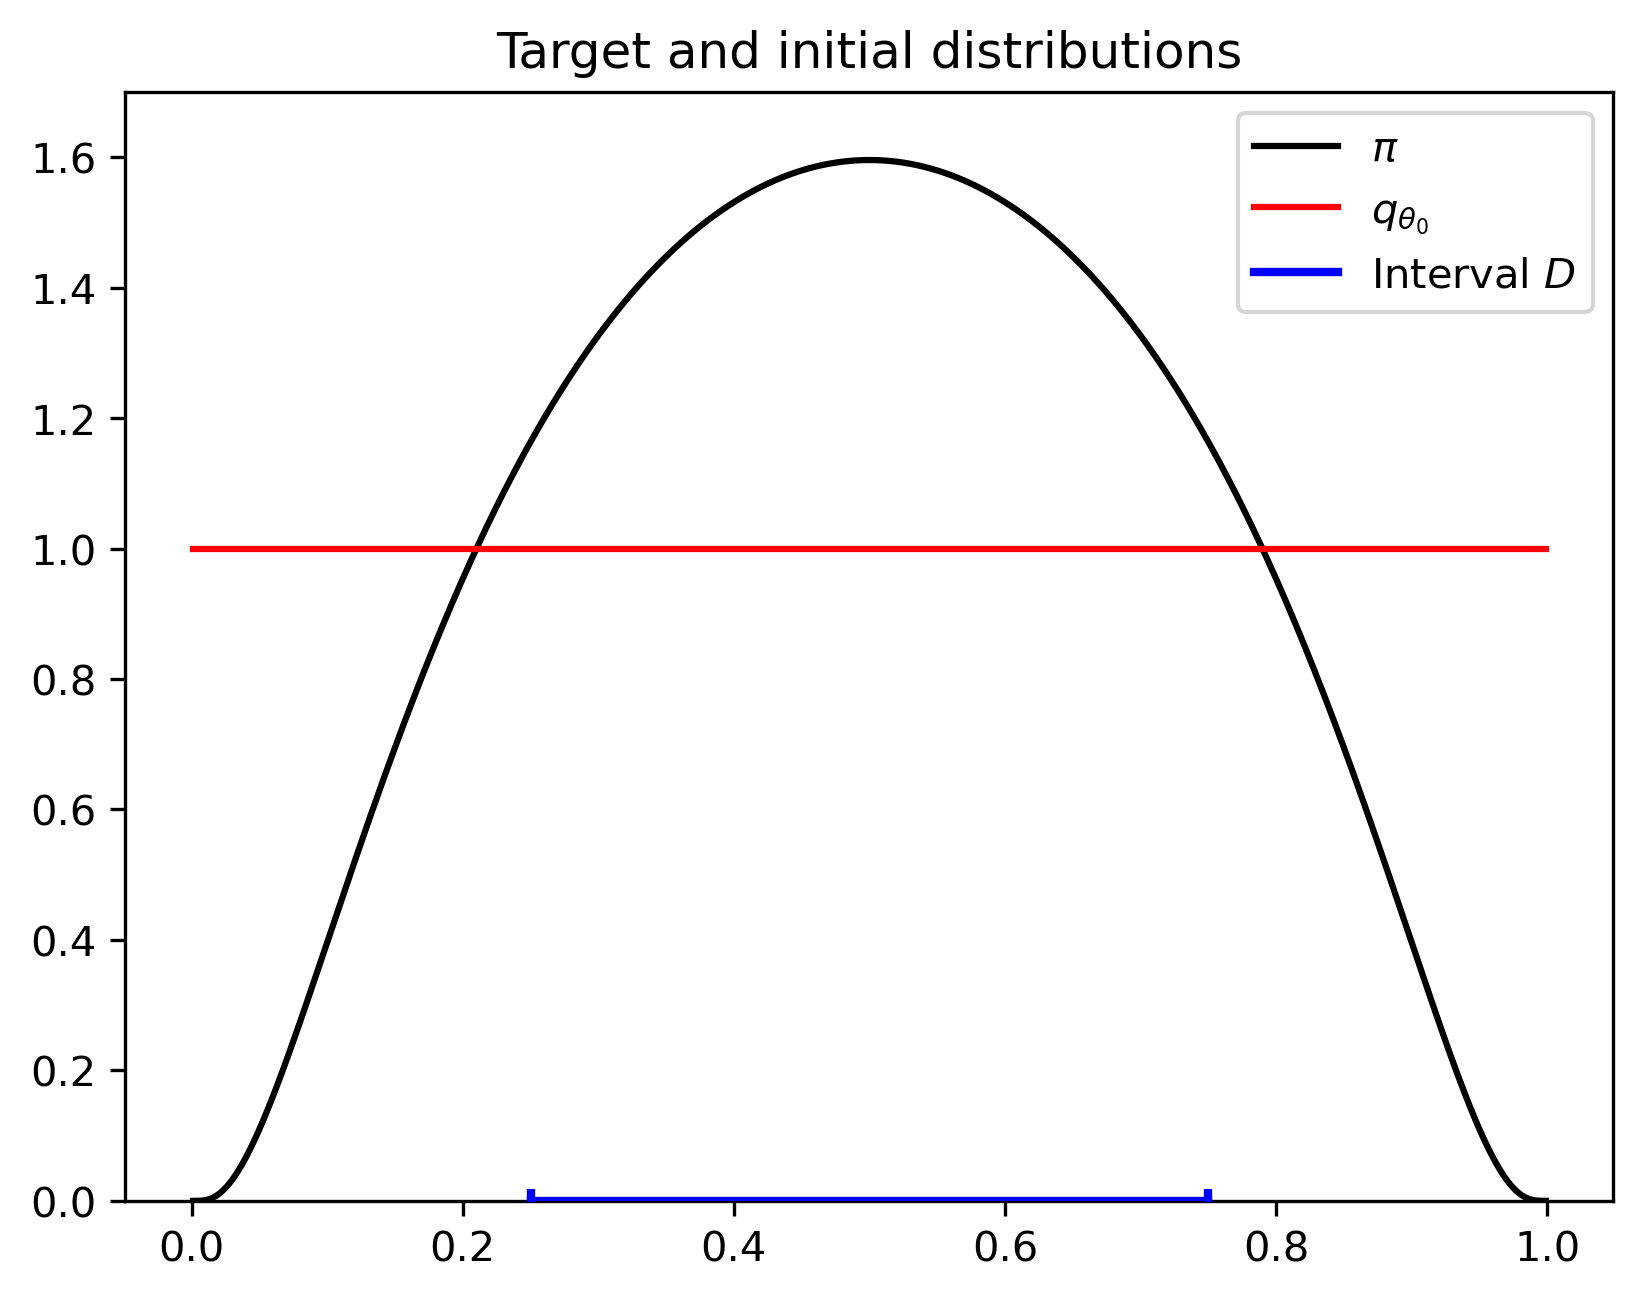

In [3]:
def phi(x):
    return (np.abs(x-0.5)<0.25).astype(float)

pi = LogitNormalRV(0, 1)
q0 = BetaRV(1, 1)

# do linspace excluding 0 and 1
x = np.linspace(0.001, 0.999, 1000)
q_pdf = q0.pdf(x)
pi_pdf = pi.pdf(x)
plt.plot(x, pi_pdf, label='$\pi$', color="black")
plt.plot(x, q_pdf, label='$q_{\\theta_0}$', color='red')
plt.title("Target and initial distributions")
plt.scatter([0.25, 0.75], [0,0], marker="|", color="blue", zorder=10000, linewidth=2)
plt.plot([0.25, 0.75], [0,0], color="blue", zorder=1000, linewidth=2, label="Interval $D$")
plt.ylim(0, 1.7)
plt.legend()


plt.show()


In [4]:
N = 100
Niter = 5*int(1e4)
nexperiments = 100
experiment_distributions = []
experiment_results = []
for experiment in range(nexperiments):
    results, distributions = Adam_OAIS_beta(phi, pi, q0, 100, Niter, alpha=1e-1)
    experiment_distributions.append(distributions)
    experiment_results.append(results)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:31<00:00, 1602.78it/s]


In [5]:
# define function to plot parameters over time
def plot_params_beta(experiment_distributions, pi, title, mode="params", average=False, Nsamples = 10000, alpha=0.2, xlog=False, ylog=False):
    alphas =  np.array([np.array([dist.alpha for dist in experiment]) for experiment in experiment_distributions])
    betas =  np.array([np.array([dist.beta for dist in experiment]) for experiment in experiment_distributions])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    if ylog:
        ax1.set_yscale("log")
        ax2.set_yscale("log")
    if xlog:
        ax1.set_xscale("log")
        ax2.set_xscale("log")
    
    if mode=="gaussian":
        pi_mean = pi.mean(Nsamples)
        pi_std = pi.std(Nsamples)
    if average:
        average_alphas = np.mean(alphas, axis=0)
        average_betas = np.mean(betas, axis=0)
        if mode=="params":
            # make 2 subplots
            ax1.plot(average_alphas, color="black")
            ax2.plot(average_betas, color="black")
            ax1.set_title("$\\alpha_k$")
            ax2.set_title("$\\beta_k$")
            ax1.set_xlabel("Iteration number")
            ax2.set_xlabel("Iteration number")
            ax1.set_ylabel("Value")
            ax2.set_ylabel("Value")
            fig.suptitle(title)
            plt.tight_layout()
        elif mode=="gaussian":
            means = average_alphas / (average_alphas + average_betas)
            stds = np.sqrt(average_alphas * average_betas / ((average_alphas + average_betas)**2 * (average_alphas + average_betas + 1)))
            ax1.plot(means, color="black")
            ax2.plot(stds, color="black")
            ax1.set_title("Mean over time")
            ax2.set_title("Standard deviation over time")
            ax1.set_xlabel("Iteration number")
            ax2.set_xlabel("Iteration number")
            ax1.set_ylabel("Value")
            ax2.set_ylabel("Value")
            ax1.hlines(pi_mean, color="red", linestyle="--", label="True mean")
            ax2.hlines(pi_std, color="red", linestyle="--", label="True std")
            fig.suptitle(title)
            plt.tight_layout()
    
    else:
        if mode=="params":
            for alpha_experiment, beta_experiment in zip(alphas, betas):
                ax1.plot(alpha_experiment, color="black", alpha=alpha)
                ax2.plot(beta_experiment, color="black", alpha=alpha)
            ax1.set_title("$\\alpha_k$")
            ax2.set_title("$\\beta_k$")
            ax1.set_xlabel("Iteration number")
            ax2.set_xlabel("Iteration number")
            ax1.set_ylabel("Value")
            ax2.set_ylabel("Value")
            fig.suptitle(title)
            plt.tight_layout()
        elif mode=="gaussian":
            for alpha_experiment, beta_experiment in zip(alphas, betas):
                means = alpha_experiment / (alpha_experiment + beta_experiment)
                stds = np.sqrt(alpha_experiment * beta_experiment / ((alpha_experiment + beta_experiment)**2 * (alpha_experiment + beta_experiment + 1)))
                ax1.plot(means, color="black", alpha=alpha)
                ax2.plot(stds, color="black", alpha=alpha)
            ax1.set_title("Mean over time")
            ax2.set_title("Standard deviation over time")
            ax1.set_xlabel("Iteration number")
            ax2.set_xlabel("Iteration number")
            ax1.set_ylabel("Value")
            ax2.set_ylabel("Value")
            ax1.hlines(pi_mean, 0, Niter, color="red", linestyle="--", label="True mean")
            ax2.hlines(pi_std, 0, Niter, color="red", linestyle="--", label="True std")
            fig.suptitle(title)
            plt.tight_layout()

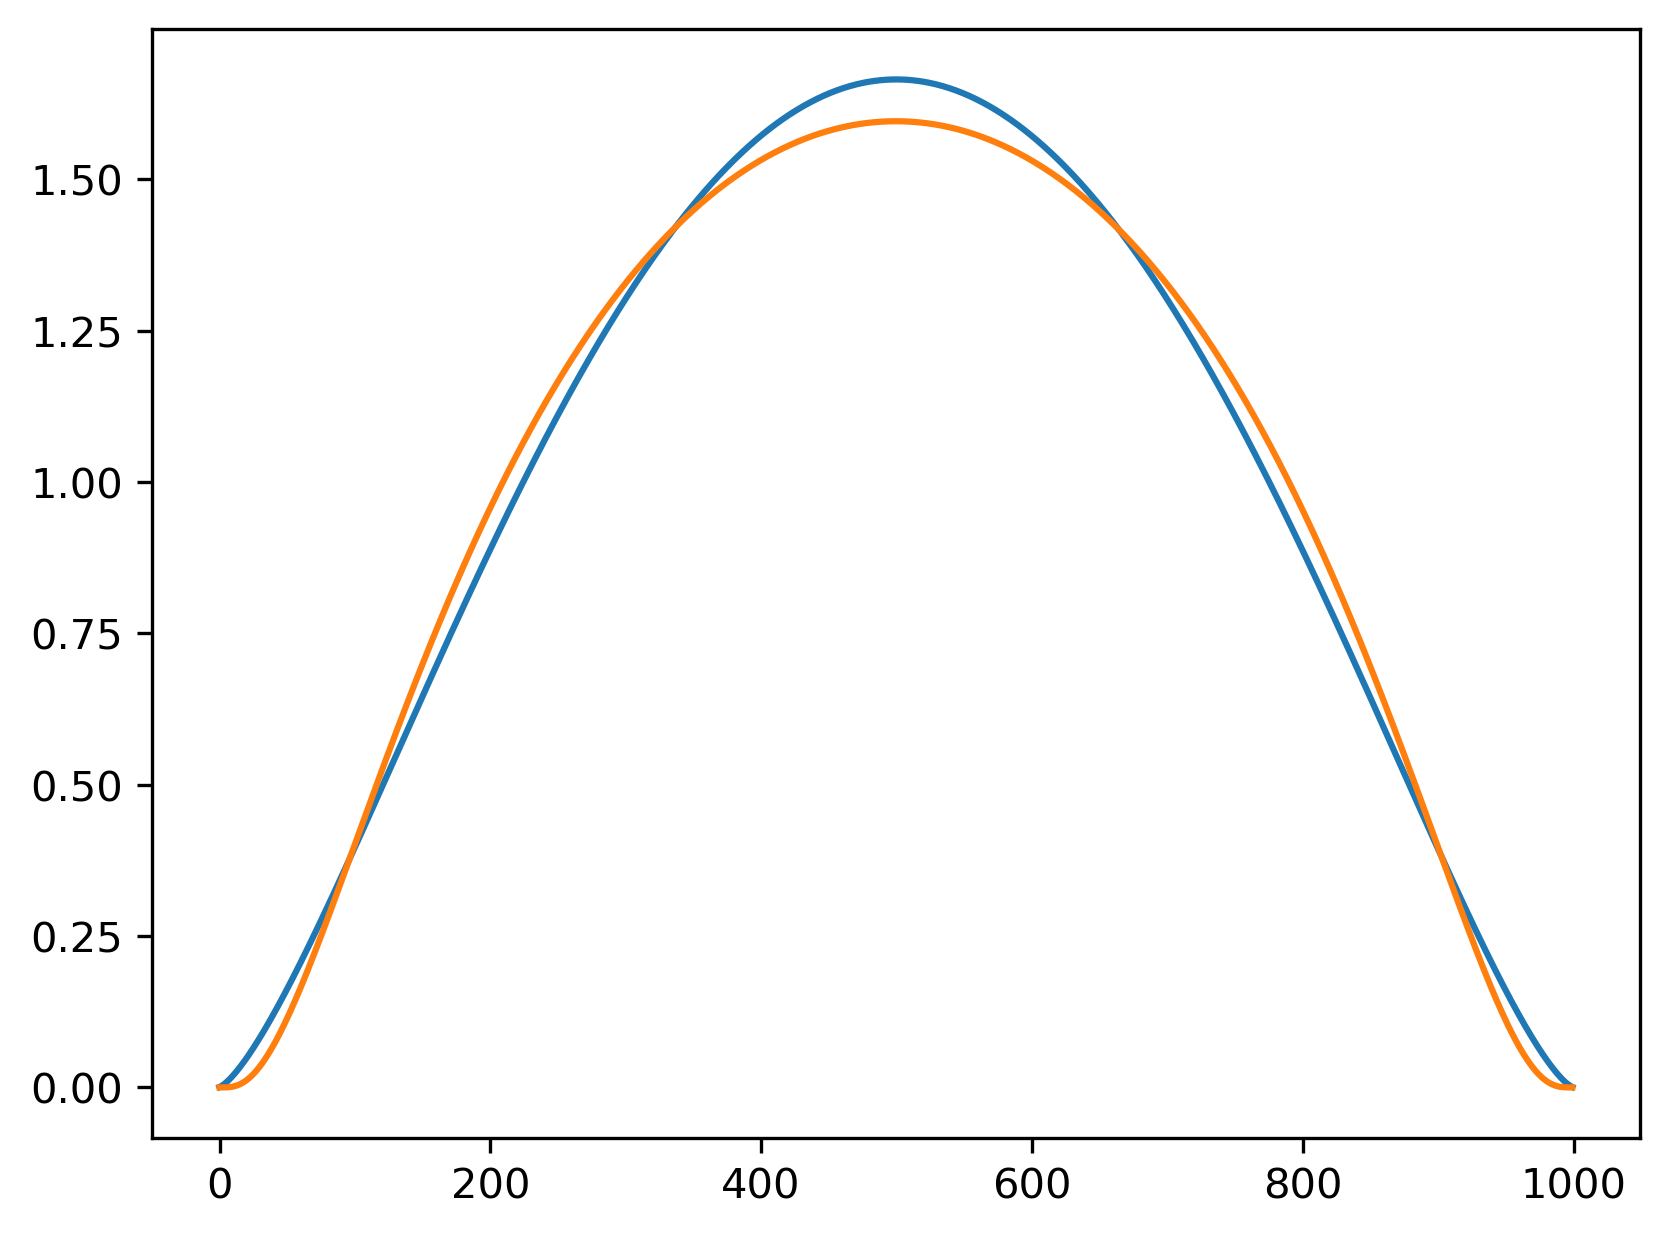

In [6]:
alphas = np.array([np.array([dist.alpha for dist in experiment]) for experiment in experiment_distributions])
betas = np.array([np.array([dist.beta for dist in experiment]) for experiment in experiment_distributions])
average_alphas = np.mean(alphas, axis=0)
average_betas = np.mean(betas, axis=0)
average_distributions = [BetaRV(average_alpha, average_beta) for average_alpha, average_beta in zip(average_alphas, average_betas)]

plt.plot(average_distributions[-1].pdf(x))
plt.plot(pi.pdf(x))

In [33]:
def plot_iters_beta(distributions, pi, title):
    grid = np.linspace(0.001, 0.999, 1000)
    Niter = len(distributions[0])
    alphas =  np.array([np.array([dist.alpha for dist in experiment]) for experiment in experiment_distributions])
    betas =  np.array([np.array([dist.beta for dist in experiment]) for experiment in experiment_distributions])
    average_alphas = np.mean(alphas, axis=0)
    average_betas = np.mean(betas, axis=0)
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    proposal_to_get = np.logspace(0, np.log10(Niter), 6, dtype=int)
    proposal_to_get[proposal_to_get==1] = 0
    for i, proposal in enumerate(proposal_to_get):
        ax = axs[i//3, i%3]
        alpha_plot = average_alphas[proposal]
        beta_plot = average_betas[proposal]
        proposal_plot = BetaRV(alpha_plot, beta_plot)
        proposal_plot_pdf = proposal_plot.pdf(grid)
        ax.plot(grid, proposal_plot_pdf, color="red", label="Proposal distribution")
        ax.plot(grid, pi.pdf(grid), color="black", label="True distribution")
        ax.set_title("Iteration {}".format(proposal))
        ax.set_xlabel("$x$")
        ax.set_ylabel("$p(x)$")
        ax.scatter([0.25, 0.75], [0,0], marker="|", color="blue", zorder=10000, linewidth=2)
        ax.plot([0.25, 0.75], [0,0], color="blue", zorder=1000, linewidth=2, label="Interval $D$")
        ax.set_ylim(0, 1.7)
        ax.legend()
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()


        
        

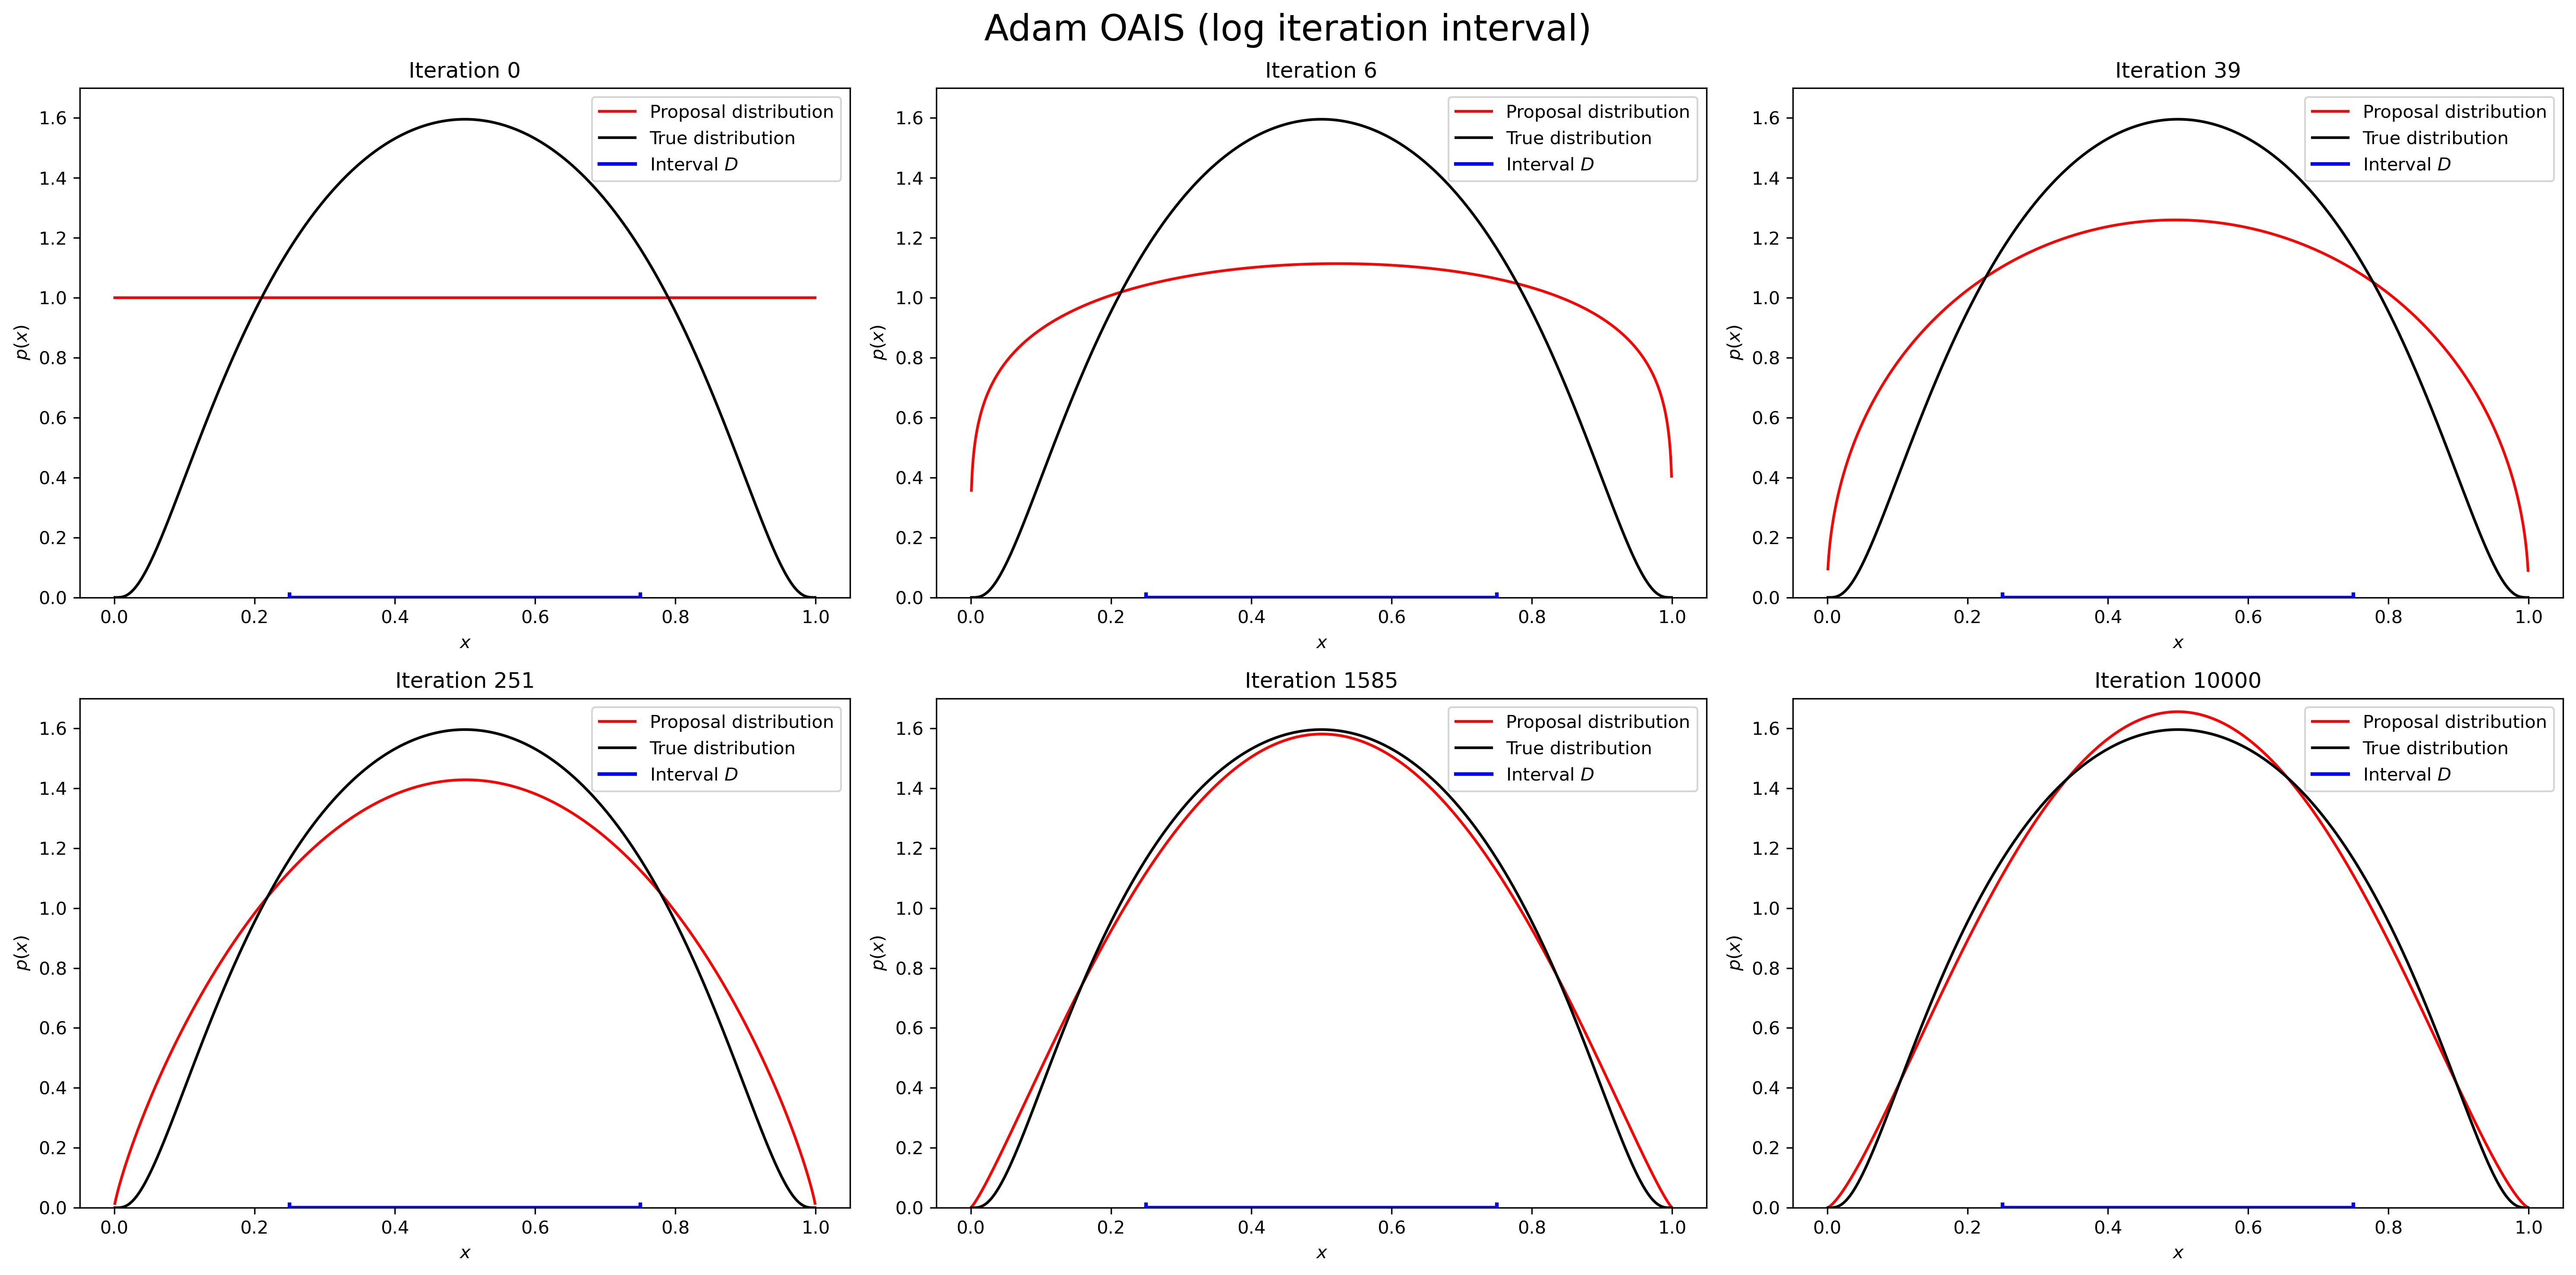

In [34]:
plot_iters(experiment_distributions, pi, "Adam OAIS (log iteration interval)")

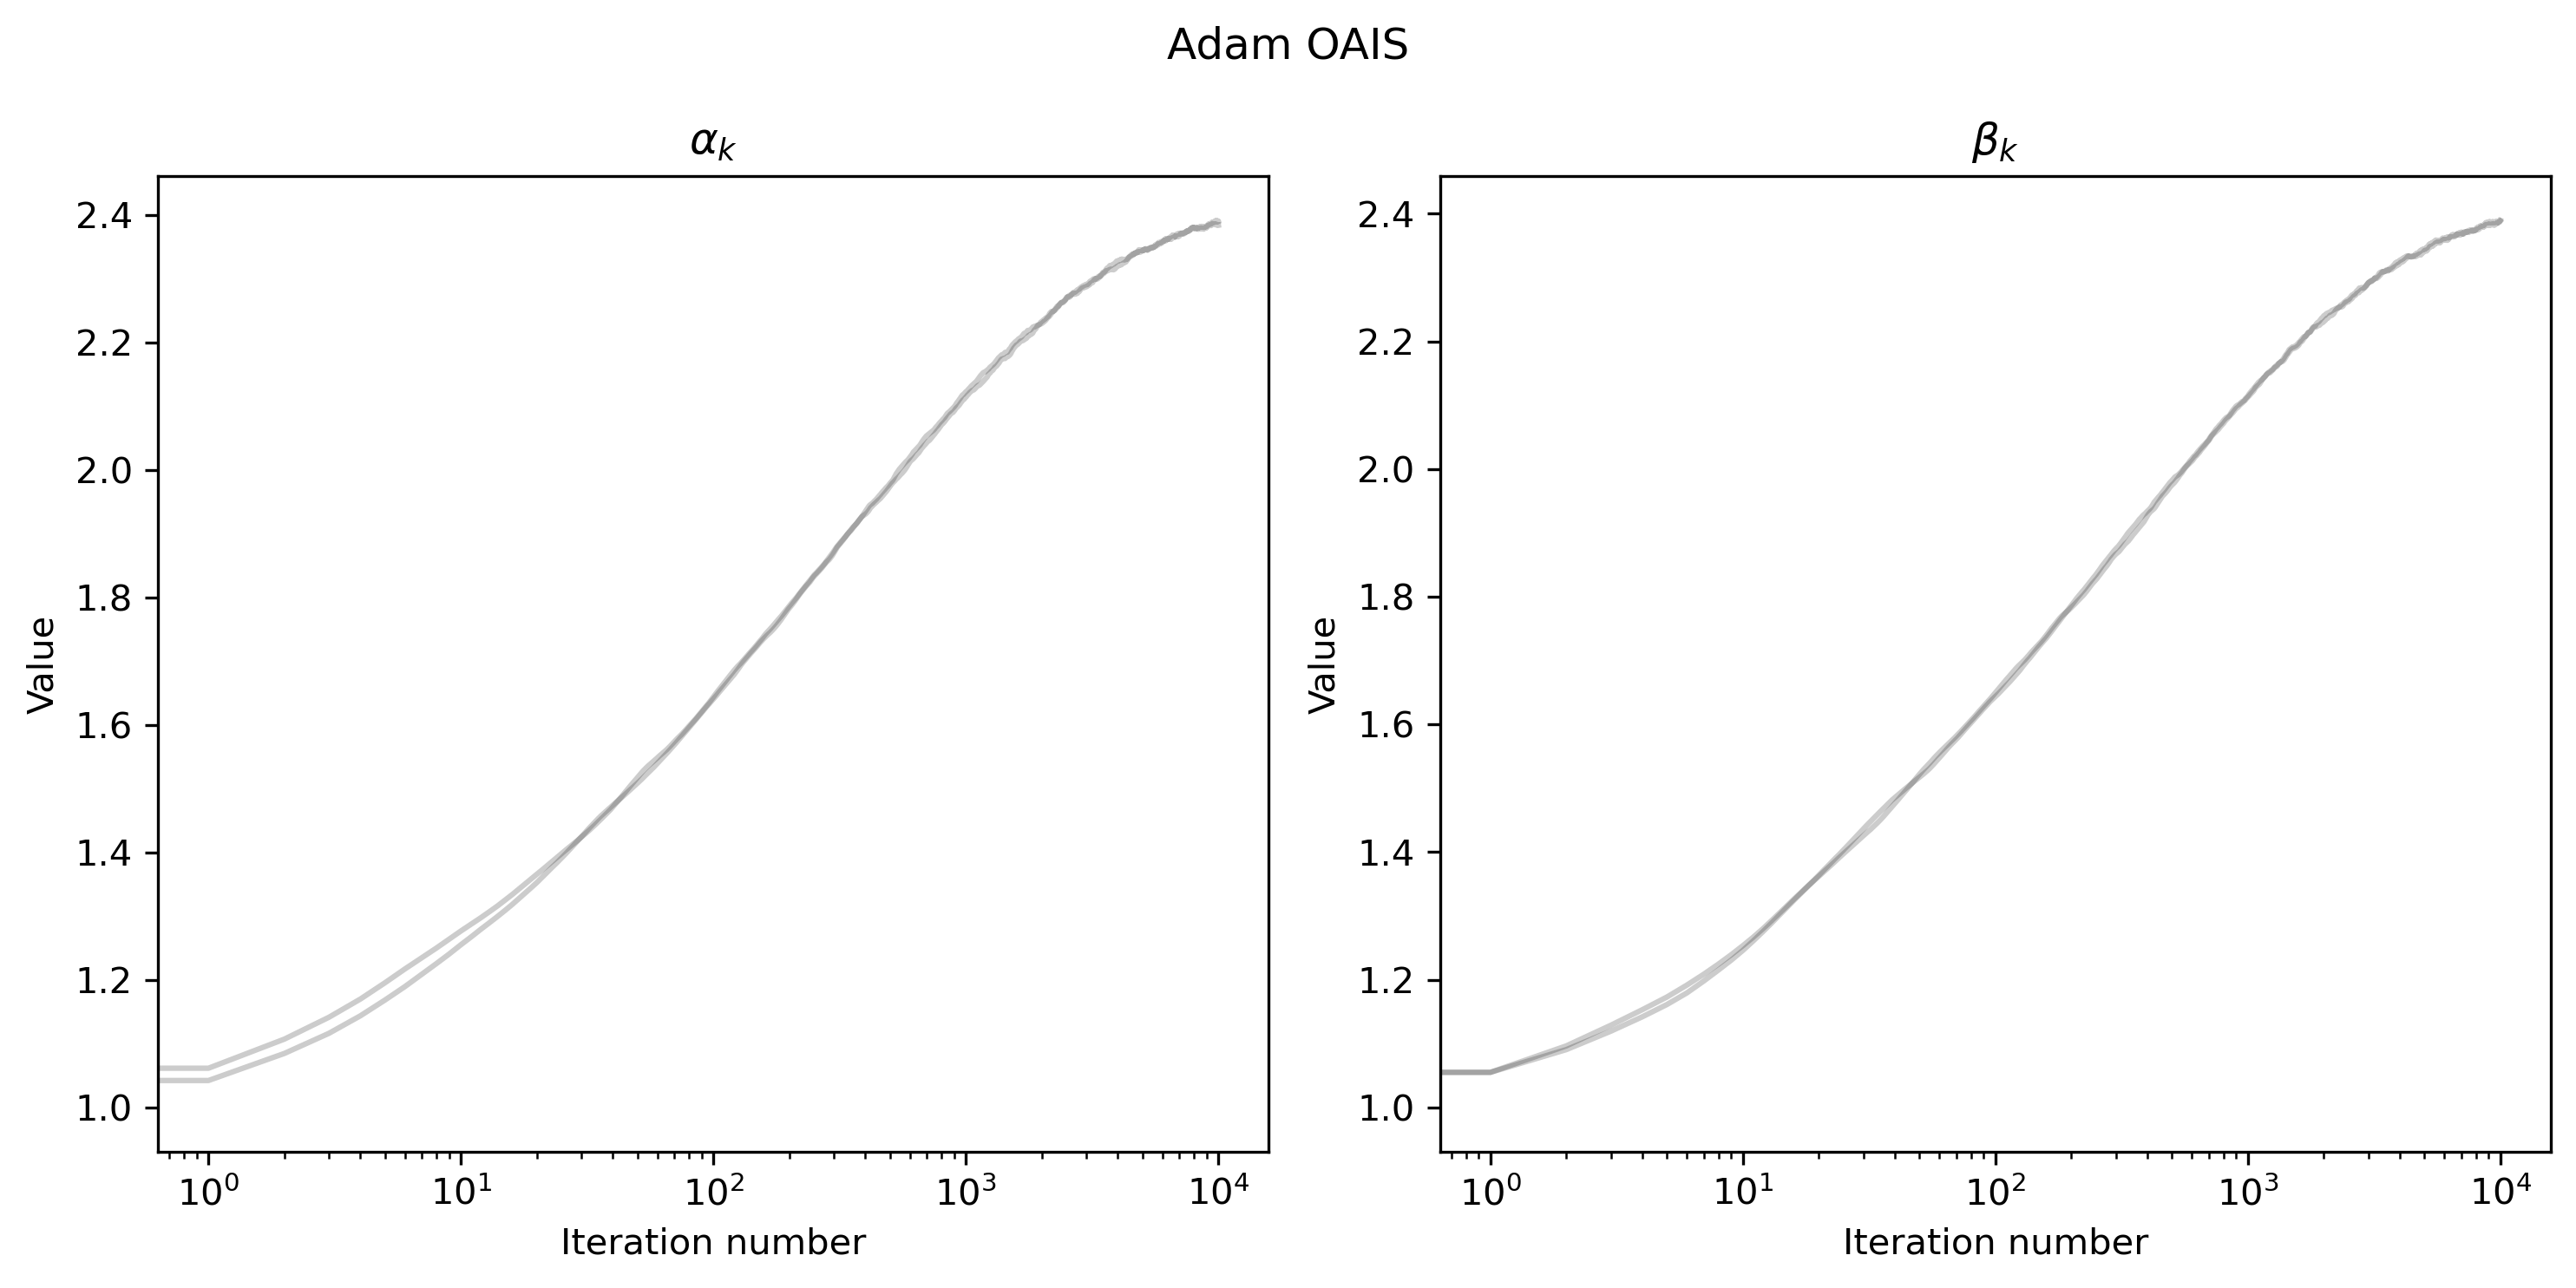

In [42]:
plot_params(experiment_distributions, pi, "Adam OAIS", mode="params", average=False, Nsamples=int(1e8), xlog=True)

In [ ]:
plot_params(experiment_distributions, pi)[0]

array([[1.        , 1.05486787, 1.08963555, ..., 2.38617975, 2.38620253,
        2.38623183],
       [1.        , 1.05994989, 1.09664218, ..., 2.38711681, 2.38714185,
        2.3871704 ]])

In [ ]:
distributions

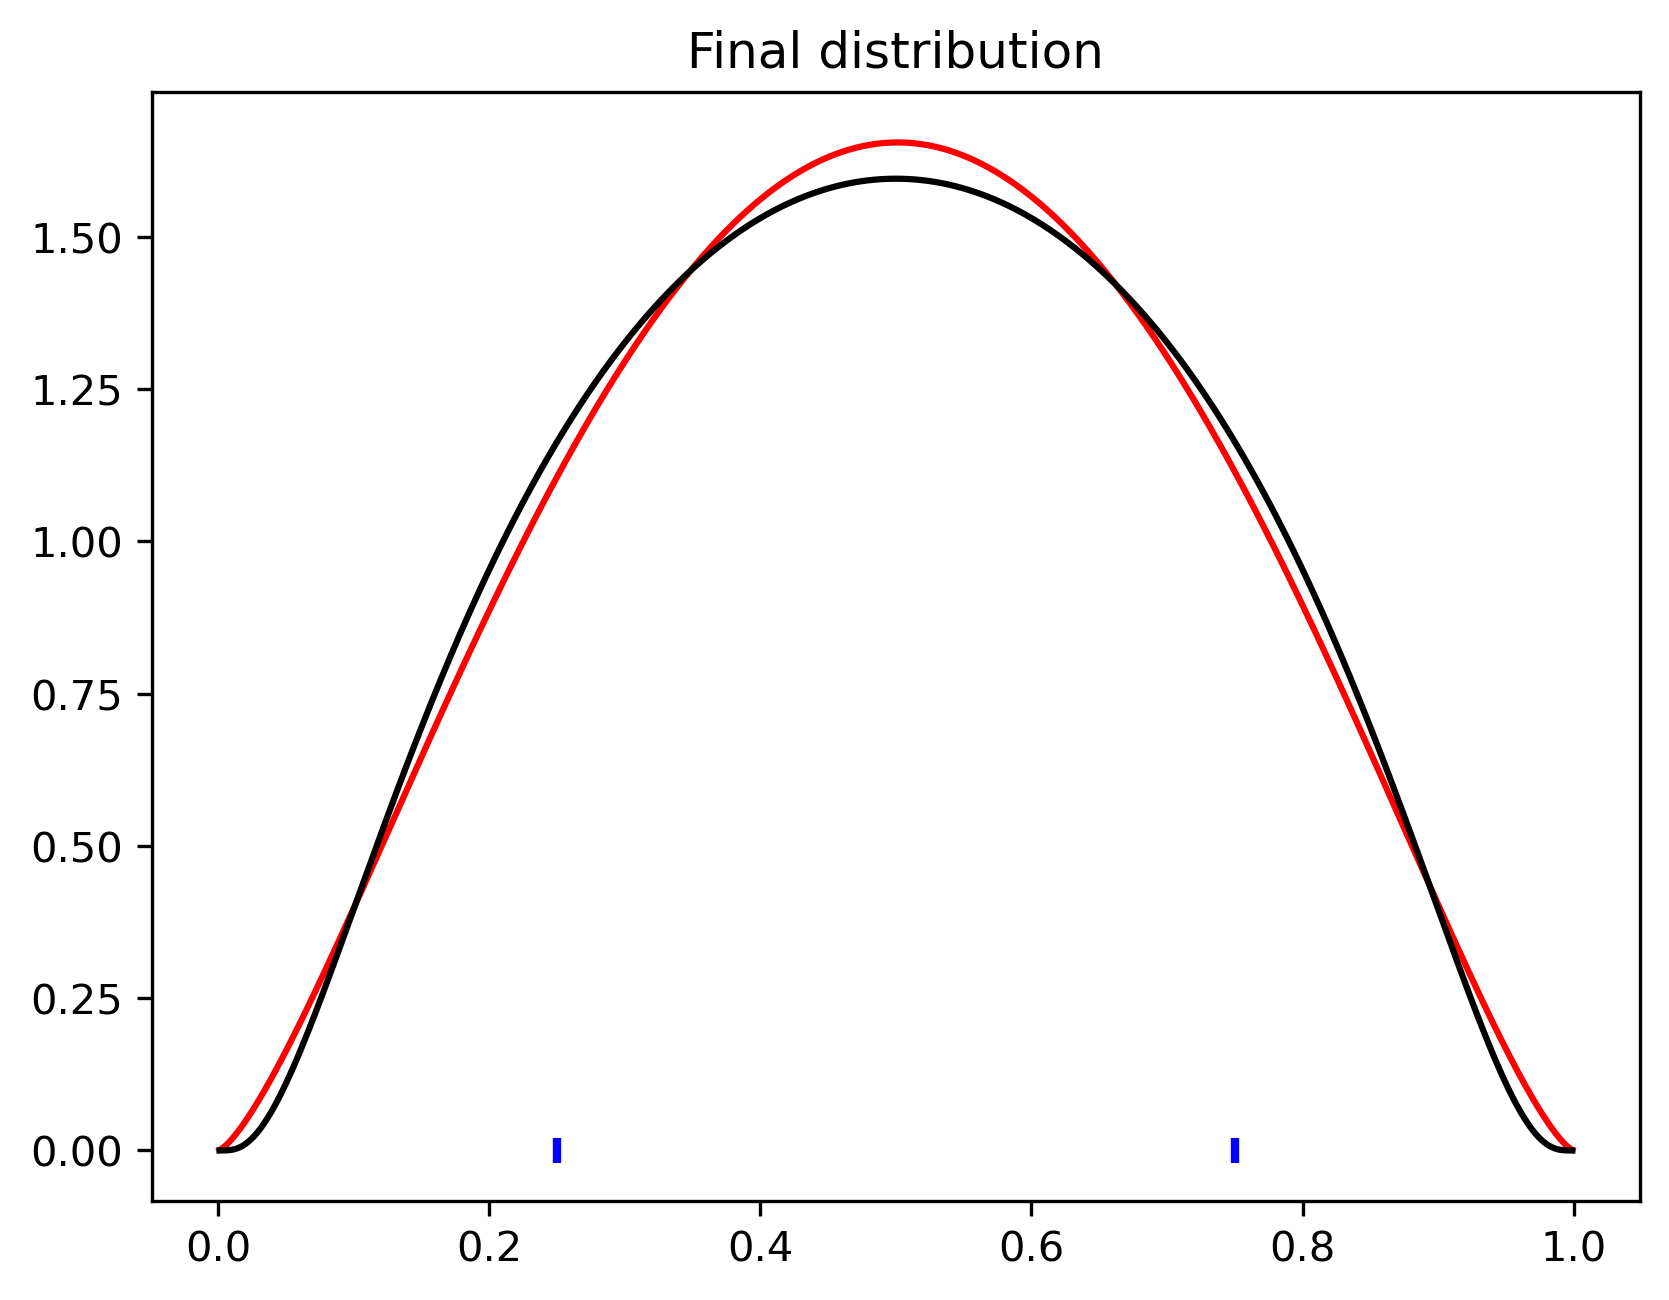

In [8]:
final_pdf = distributions[-1].pdf(x)
plt.plot(x, final_pdf, label='$q_{\\theta_{final}}$', color='red')
plt.plot(x, pi_pdf, label='$\pi$', color="black")
plt.title("Final distribution")
plt.scatter([0.25, 0.75], [0,0], marker="|", color="blue", zorder=10000, linewidth=2)

In [ ]:
def plot_mse_beta(results_list, GT, title, xlog = False, ylog=False):
    results = np.array(results_list)
    mses = np.mean((results-GT)**2, axis=0)
    plt.plot(mses, color="black", linewidth=1)
    plt.title(title, fontsize=20)
    plt.xlabel("Iteration number")
    plt.ylabel("MSE")
    if xlog:
        plt.xscale("log")
    if ylog:
        plt.yscale("log")
    plt.tight_layout()




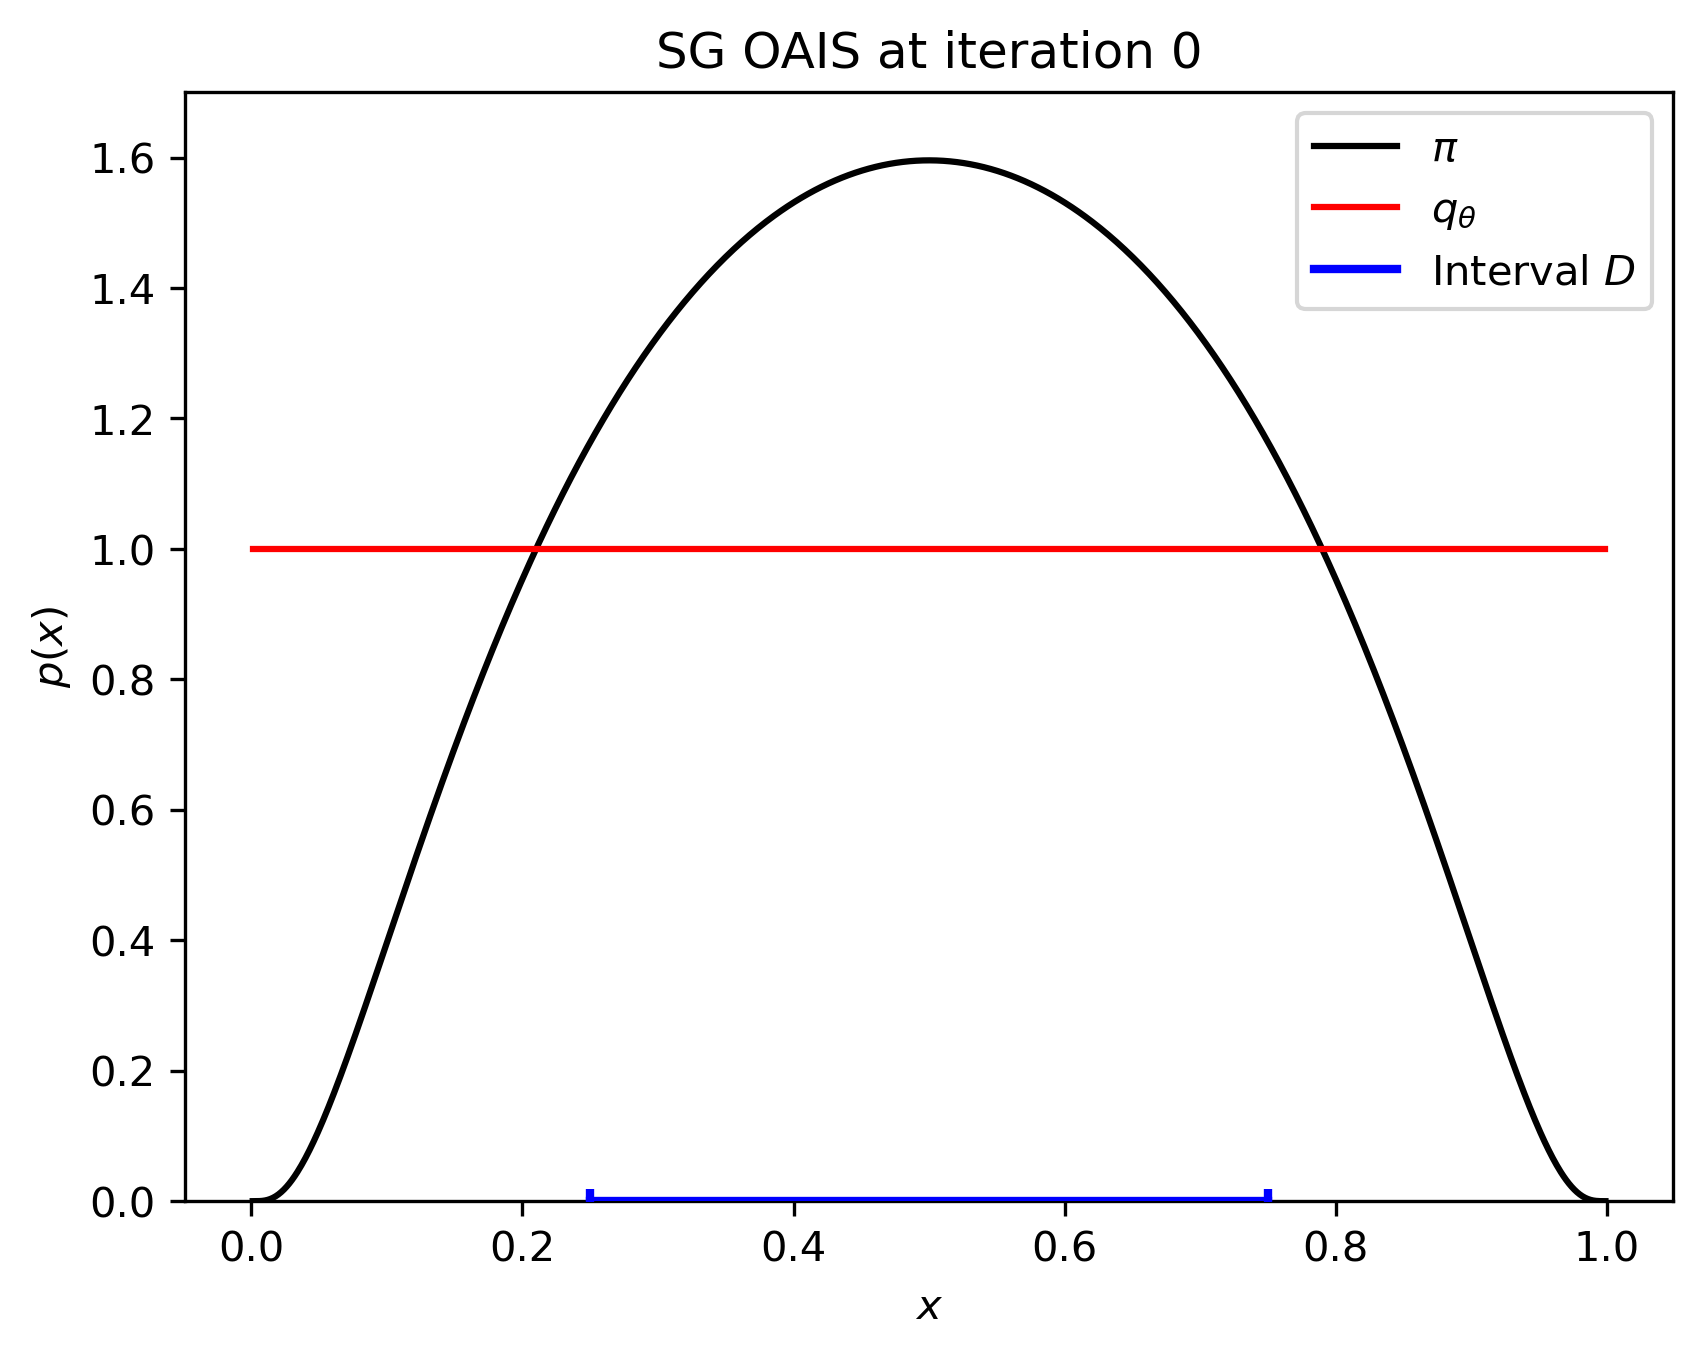

done saving


In [10]:
fig, ax = plt.subplots()

ax.plot(x, pi_pdf, color="black", label="$\pi$")
pdf_i = [d.pdf(x) for d in distributions]
proposal = ax.plot(x, pdf_i[0], color="red", label="$q_{\\theta}$")
ax.set_xlabel("$x$")
ax.set_ylabel("$p(x)$")
ax.set_title("SG-OAIS with beta proposal and logit-normal target")
ax.scatter([0.25, 0.75], [0,0], marker="|", color="blue", zorder=10000, linewidth=2)
ax.plot([0.25, 0.75], [0,0], color="blue", zorder=1000, linewidth=2, label="Interval $D$")
ax.set_title("SG OAIS at iteration {}".format(0))
ax.set_ylim(0, 1.7)
plt.legend()


def animate(i):
    proposal[0].set_ydata(pdf_i[i])
    ax.set_title("SG OAIS at iteration {}".format(i))
    return proposal
plt.show()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim = FuncAnimation(fig, animate, frames=range(0, len(distributions)-1), interval=10, repeat=False, blit=True)
anim.save('/Users/carlosperello/Desktop/M3R/figs/beta/betaOAIS_iters.mp4', writer=writer)
print("done saving")
plt.show()

Text(0.5, 1.0, 'Final distribution')

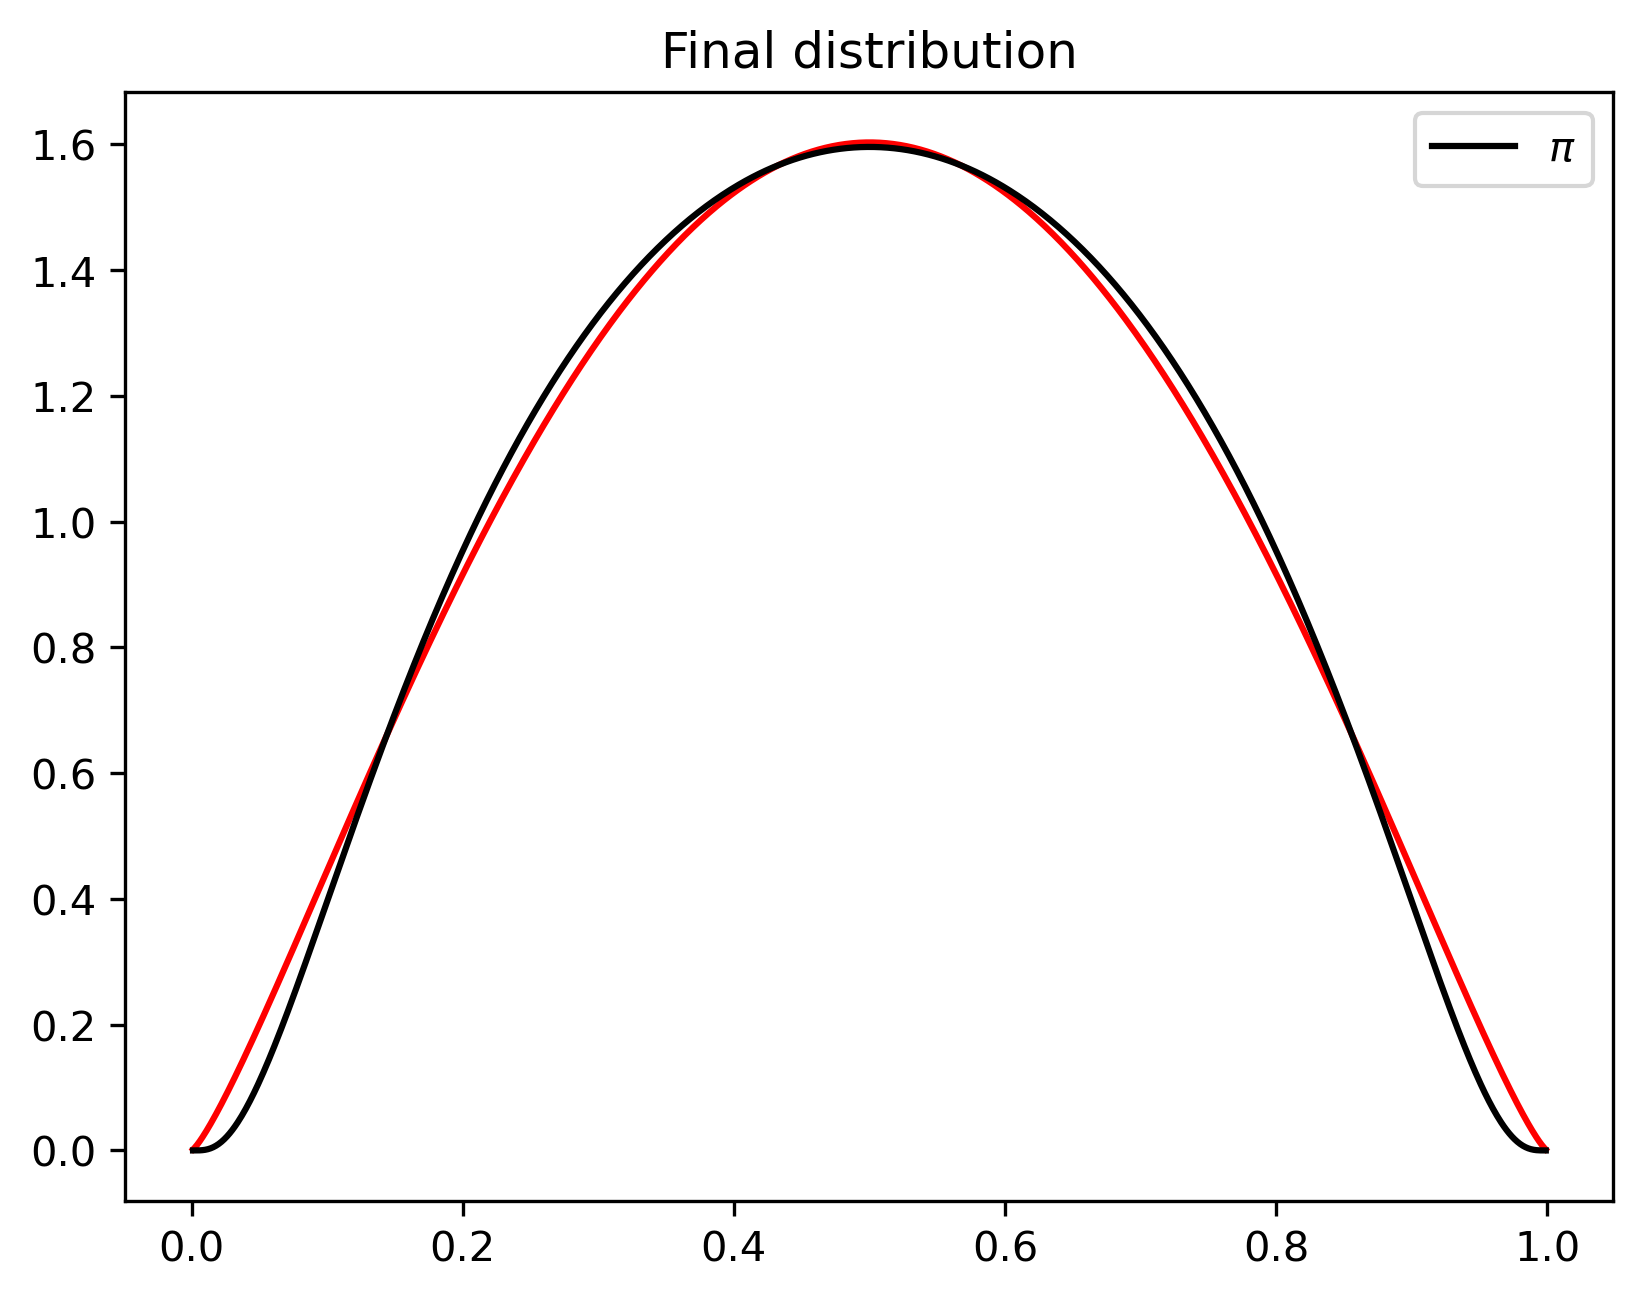

In [47]:
plt.plot(x, distributions[-1].pdf(x), color="red")
plt.plot(x, pi_pdf, label='$\pi$', color="black")
plt.legend()
plt.title("Final distribution")

100%|██████████| 10001/10001 [00:09<00:00, 1078.24it/s]


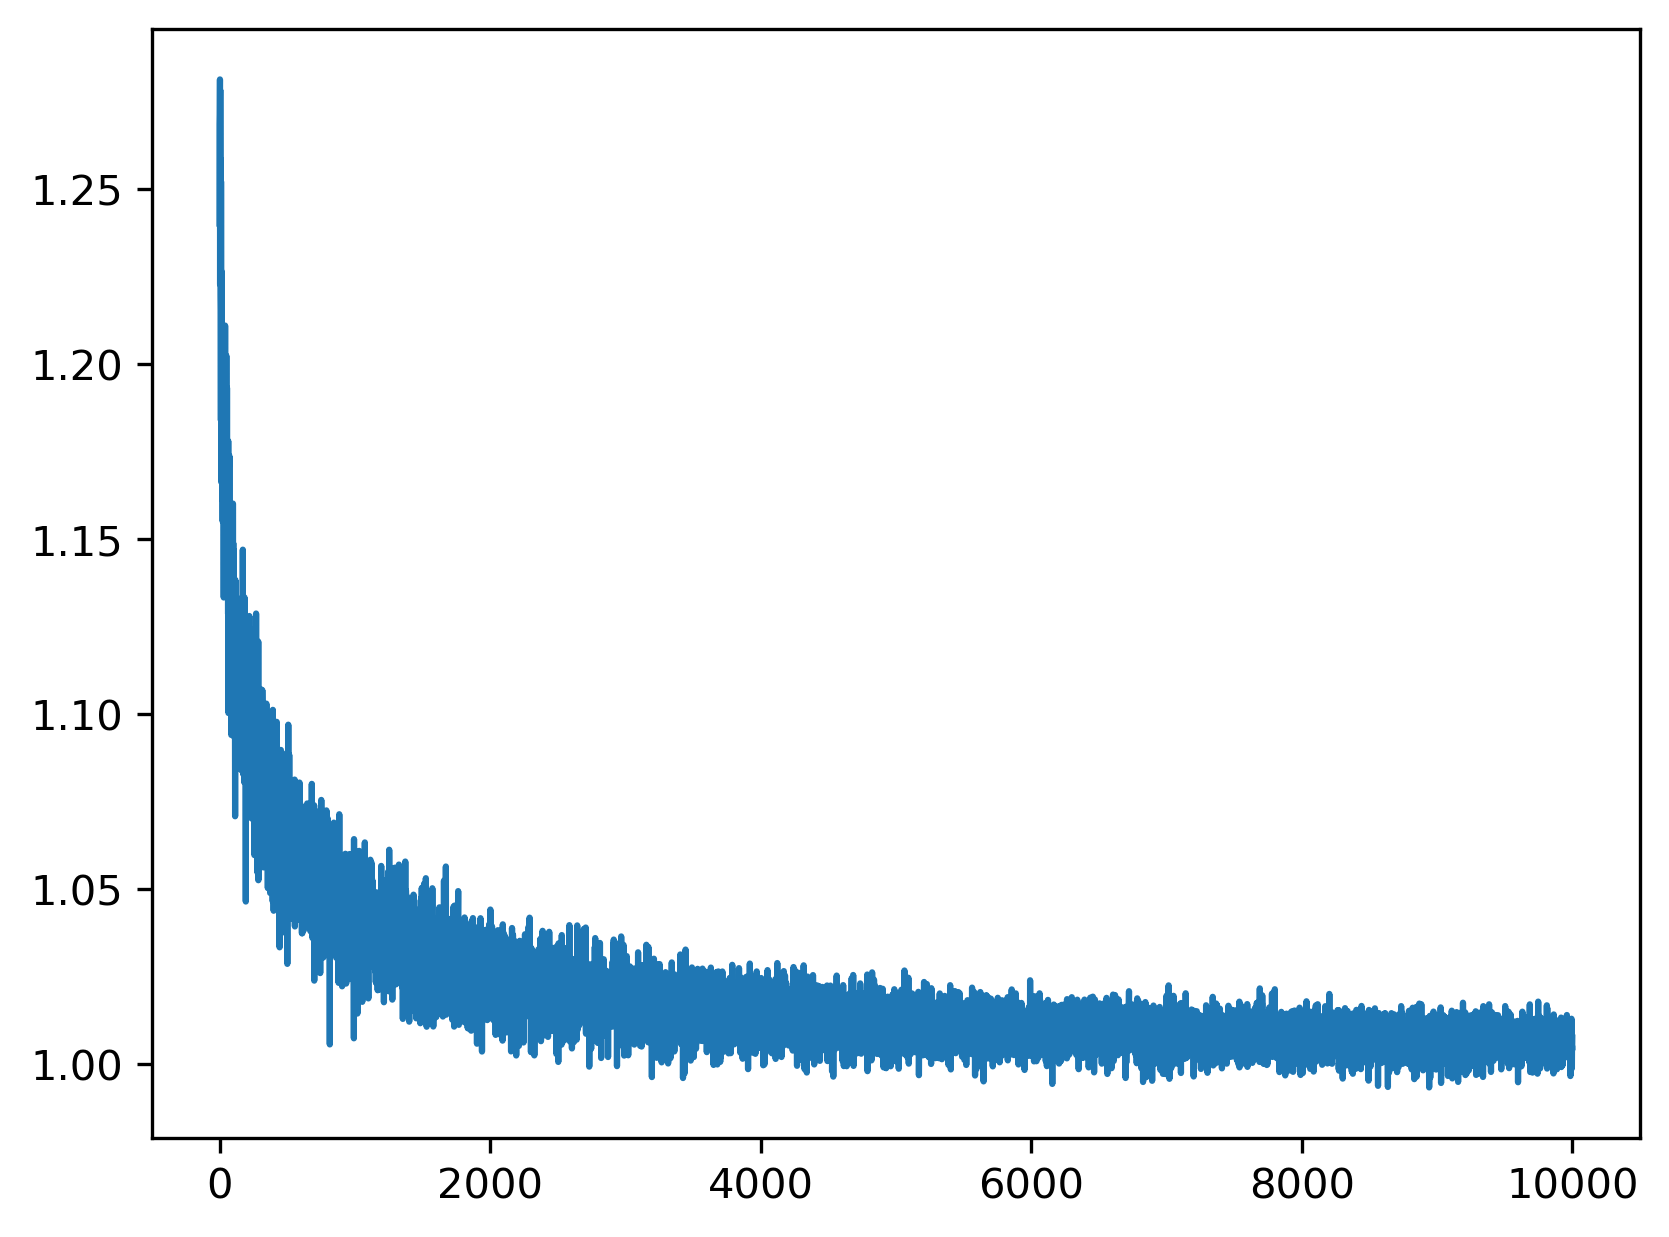

In [46]:
rho_vals = []

for i in tqdm(range(len(distributions))):
    rho_vals.append(rho(pi, distributions[i], 1000))

plt.plot(rho_vals)